In [1]:
import autoreload
%load_ext autoreload
%autoreload 2

import glob
import os

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from fcsutils import FcsTrajectory
from fcsfit import *

from fcsutils import readfcsfile

%matplotlib inline

/Users/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
## Get the raw files with glob
files = glob.glob('Data/FCS_raw/dish1-raw/*.raw')
len(files)

150

In [6]:
### read one file and do calculations
### the ftrip is set to 0.23, just for fun

ff = files[np.random.randint(0, len(files))]
print(os.path.basename(ff))
c = FcsTrajectory(ff, 20e-6)
c()

## do some fitting
## one component fit
fcs1 = fcs_1comp(p0 = [.1, .001, 0])

## 1 component fit with triplet - ftrip and ttrip fixed
ftrip = .23
fcst = fcs_1comp_triplet(p0=[.05, .001, 0], bounds=None)
fcst.fix(ftrip, 250e-6)

## do the fitting - p1 and pt are parameter arrays
p1, _ = fcs1(c.actime, c.autocorr)
pt, _ = fcst(c.actime, c.autocorr)

print("Single component: G0: {:6.3e}, taud: {:6.3e}, offset:{:6.3e}".format(*p1))
print("Single component: G0: {:6.3e}, taud: {:6.3e}, offset:{:6.3e}, ftrip:{}, ttrip:{}".format(*pt, ftrip, 250e-6))

dish1-1per-pow-12_ac6183ec40ba5b002331fa89f7d222f_R6_P1_K1_ChS1.raw
Single component: G0: 7.942e-02, taud: 1.196e-03, offset:1.070e-04
Single component: G0: 6.682e-02, taud: 1.763e-03, offset:-5.516e-04, ftrip:0.23, ttrip:0.00025


0.019960110566385327

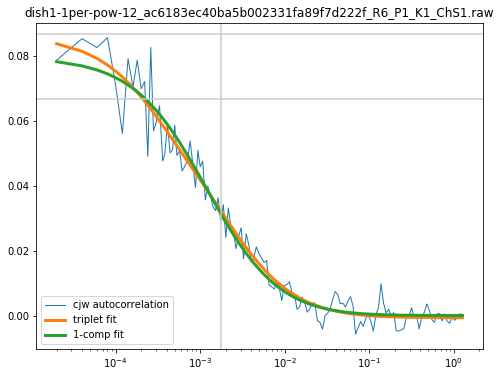

In [7]:

plt.figure(figsize=(8,6))
plt.semilogx(c.actime, c.autocorr, marker=None,
             linewidth=1,label="cjw autocorrelation")
plt.semilogx(c.actime, fcst.predict(c.actime),
             linewidth=3,label="triplet fit")
plt.semilogx(c.actime, fcs1.predict(c.actime),
             linewidth=3, label="1-comp fit")
plt.title(os.path.basename(c.filename))
plt.axvline(fcst.popt[1], color='#cccccc')
plt.axhline(fcst.popt[0] + fcst.popt[0]*ftrip/(1- ftrip), color='#cccccc')
plt.axhline(fcst.popt[0], color='#cccccc')
plt.legend()
fcst.popt[0]*ftrip/(1- ftrip)


In [8]:
### read all of the raw files into into a DataFrame

df_list = list()
trip_fits_list = list()
scomp_fits_list = list()
## read raw files and do autocorrelation, put everthing in one dataframe
for f in files:
    fcs = FcsTrajectory(f, 2e-5) ## setup the object with filename and binsize
    fcs()                        ## calculate the trajectory and autocorrelation
    _df = fcs.ac_as_dataframe()  ## dataframe of tau and autocorrelation
    _df['name'] = os.path.basename(f).split("-")[0]
    df_list.append(_df)
    
df = pd.concat(df_list, axis=0)


In [9]:
### Fit all of the curves with 1) Single Component 2) Single Component * triplet

fcst = fcs_1comp_triplet(p0=[.01, .001, 0])
fcst.fix(.05, 250e-6)
trip_fits_list = list()
scomp_fits_list = list()
for z, _df in df.groupby('file'):
    try:
        pt, perrt = fcst(_df.tau, _df.autocorr)  # triplet fitting model
        trip_fits_list.append({'g0':pt[0], 'taud':pt[1],
                        'ttrip':250e-6,
                        'offset':pt[2],
                        'fit':'triplet',
                        'name':_df.name[0],
                        'file':z})
    except Exception as e:
        print(e)

    try:
        p1, _ = fcs1(_df.tau, _df.autocorr)      # 1 component model
        scomp_fits_list.append({'g0':p1[0], 'taud':p1[1],
                      'offset':p1[2],
                      'fit':'1comp',
                      'name':_df.name[0],
                      'file':z})
    except:
        pass

trip_fits = pd.DataFrame(trip_fits_list)
scomp_fits = pd.DataFrame(scomp_fits_list)

/Users/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
## this is from the imagej plugin plot window
cv = pd.read_csv('Data/corr_and_fit.csv')

#fit values from analysis spreadsheet (ftrip=0.05, ttrip=250e-6) 
pcomp = [0.07745, 1.729e-3, -1.4e-4]

## use the means of the fits to plot the fit
ptrip = [trip_fits.g0.mean(), trip_fits.taud.mean(), trip_fits.offset.mean()]
p1comp = [scomp_fits.g0.mean(), scomp_fits.taud.mean(), scomp_fits.offset.mean()]



1-component G0: 8.611e-02, taud: 9.676e-04, offset:9.831e-04
Triplet     G0: 8.286e-02, taud: 1.047e-03, offset:8.474e-04, ftrip:0.05, ttrip:0.00025
ImageJ      G0: 7.745e-02, taud: 1.729e-03, offset:-1.400e-04, ftrip:0.05, ttrip:0.00025


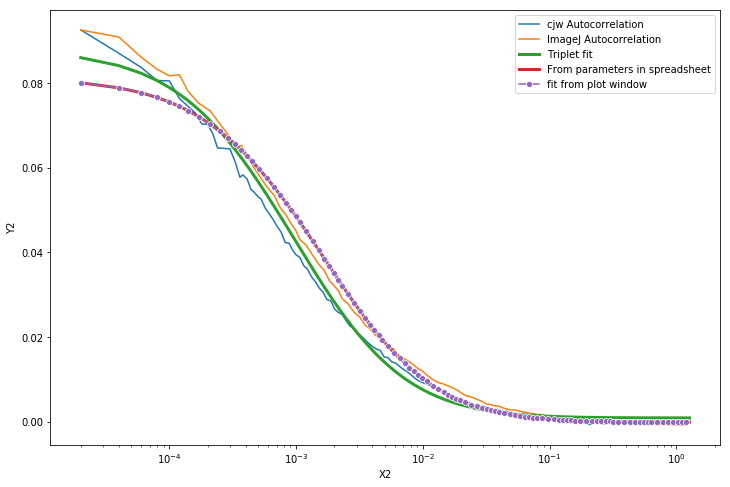

In [18]:
%matplotlib inline
qtau = df.tau.unique()

cfcs = fcs_1comp_triplet(p0=[.01, .001, 0])
cfcs.fix(0.05, 250e-6)

plt.figure(figsize=(12,8))
sns.lineplot(x='tau', y='autocorr', estimator=np.mean, data=df,
             ci=None, marker=None, label="cjw Autocorrelation")
sns.lineplot(x='X1', y='Y1', data=cv, marker=None, label="ImageJ Autocorrelation")

sns.lineplot(x=qtau, y=fcst.predict(qtau, p=ptrip),
             linewidth=3, label="Triplet fit")

sns.lineplot(x=qtau, y=cfcs.predict(qtau, p=pcomp),
             linewidth=3,label="From parameters in spreadsheet")

sns.lineplot(x='X2', y='Y2', data=cv, marker='o', label="fit from plot window")

plt.xscale('log')
plt.legend()

print("1-component G0: {:6.3e}, taud: {:6.3e}, offset:{:6.3e}".format(*p1comp))
print("Triplet     G0: {:6.3e}, taud: {:6.3e}, offset:{:6.3e}, ftrip:{}, ttrip:{}".format(*ptrip, 0.05, 250e-6))

print("ImageJ      G0: {:6.3e}, taud: {:6.3e}, offset:{:6.3e}, ftrip:{}, ttrip:{}".format(*pcomp, 0.05, 250e-6))